# 1. Import Required Libraries

In this section, we import all the necessary Python libraries and modules required for running the TransPhaser example workflow. Each library serves a specific purpose:
- **torch**: For deep learning operations and model training.
- **pandas** and **numpy**: For data manipulation and numerical computations.
- **os** and **random**: For file operations and reproducibility.
- **logging**: For tracking the workflow progress and debugging.
- **matplotlib.pyplot**: For visualizing training and validation loss curves.
- **sklearn.model_selection.train_test_split**: For splitting the dataset into training and validation sets.
- **torch.utils.data.DataLoader**: For batching and loading data efficiently during training.
- **TransPhaser modules**: For configuration, data preprocessing, model definition, training, evaluation, and uncertainty estimation.

Importing these libraries ensures that all dependencies are available and the workflow can proceed smoothly.

In [17]:
import torch
import pandas as pd
import numpy as np
import os
import random
import logging
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# --- Import TransPhaser Components ---
from transphaser.config import HLAPhasingConfig, DataConfig, ModelConfig, TrainingConfig
from transphaser.data_preprocessing import GenotypeDataParser, AlleleTokenizer, CovariateEncoder, HLADataset
from transphaser.model import HLAPhasingModel
from transphaser.trainer import HLAPhasingTrainer
from transphaser.loss import ELBOLoss, KLAnnealingScheduler
from torch.optim import Adam
from transphaser.evaluation import HLAPhasingMetrics, PhasingUncertaintyEstimator

# 2. Load Example Data

In this section, we load the synthetic genotype and haplotype data required for phasing. The data consists of:
- **Unphased genotype data**: Contains genotype information for each individual, which needs to be phased.
- **Phased haplotype data**: Contains the ground truth haplotypes for evaluation purposes.

Loading the data is essential because the phaser algorithm requires both the input genotypes and the ground truth for training and evaluation. We also set up the output directory and random seeds for reproducibility.

In [18]:
# Set up paths and device
DATA_DIR = "examples/data"
UNPHASED_DATA_FILE = os.path.join(DATA_DIR, "synthetic_genotypes_unphased.csv")
PHASED_DATA_FILE = os.path.join(DATA_DIR, "synthetic_haplotypes_phased.csv")
OUTPUT_DIR = "examples/output"
MODEL_CHECKPOINT_PATH = os.path.join(OUTPUT_DIR, "phaser_model_example.pt")
PREDICTIONS_FILE = os.path.join(OUTPUT_DIR, "predictions.csv")
EVALUATION_FILE = os.path.join(OUTPUT_DIR, "evaluation_metrics.txt")
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Logging setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info(f"Using device: {DEVICE}")

# Set random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load data
logging.info("Loading data...")
df_unphased = pd.read_csv(UNPHASED_DATA_FILE)
df_phased_truth = pd.read_csv(PHASED_DATA_FILE)

2025-08-25 15:29:18,696 - INFO - Using device: cpu
2025-08-25 15:29:18,700 - INFO - Loading data...
2025-08-25 15:29:18,700 - INFO - Loading data...


# 3. Initialize Phaser Object

In this section, we configure and initialize the core components required for phasing. This includes:
- Identifying loci and covariates from the data.
- Building allele vocabularies and covariate encoders.
- Creating configuration objects for data, model, and training.
- Initializing the TransPhaser model and trainer.

Proper initialization ensures that the model understands the structure of the data and is ready for training. Each configuration parameter can affect the model's performance and behavior.

In [19]:
# Identify loci and covariates
loci = ['HLA-A', 'HLA-B', 'HLA-DRB1']
covariate_cols = ['Population', 'AgeGroup']
logging.info(f"Identified Loci: {loci}")
logging.info(f"Identified Covariates: {covariate_cols}")

# Build allele vocabularies
parser = GenotypeDataParser(locus_columns=loci, covariate_columns=covariate_cols)
all_alleles_set = set()
for locus in loci:
    for genotype_str in df_unphased[locus].dropna():
        alleles = genotype_str.split('/')
        all_alleles_set.update(alleles)
all_alleles = list(all_alleles_set)
if "<UNK>" in all_alleles: all_alleles.remove("<UNK>")
if "UNK" in all_alleles: all_alleles.remove("UNK")
alleles_by_locus = {}
for locus in loci:
    locus_alleles = set()
    for genotype_str in df_unphased[locus].dropna():
        alleles = genotype_str.split('/')
        locus_alleles.update(alleles)
    if "<UNK>" in locus_alleles: locus_alleles.remove("<UNK>")
    if "UNK" in locus_alleles: locus_alleles.remove("UNK")
    alleles_by_locus[locus] = list(locus_alleles)
allele_tokenizer = AlleleTokenizer()
logging.info("Building allele vocabularies...")
for locus, locus_alleles_list in alleles_by_locus.items():
    allele_tokenizer.build_vocabulary(locus, locus_alleles_list)
    logging.info(f"  {locus}: {allele_tokenizer.get_vocab_size(locus)} tokens")

# Covariate encoder
categorical_covariate_cols = covariate_cols
numerical_covariate_cols = []
covariate_encoder = CovariateEncoder(
    categorical_covariates=categorical_covariate_cols,
    numerical_covariates=numerical_covariate_cols
)

# Config objects
vocab_sizes = {locus: allele_tokenizer.get_vocab_size(locus) for locus in loci}
data_cfg = DataConfig(locus_columns=loci, covariate_columns=covariate_cols)
model_cfg = ModelConfig(embedding_dim=64, latent_dim=32, num_layers=2, num_heads=4, ff_dim=16, dropout=0.1)
training_cfg = TrainingConfig(batch_size=32, learning_rate=1e-4, epochs=5)
config = HLAPhasingConfig(
    data=data_cfg,
    model=model_cfg,
    training=training_cfg,
    device=str(DEVICE),
    seed=SEED
)
logging.info(f"Allele Vocab Sizes determined: {vocab_sizes}")

# Preprocess data and create datasets
train_df, val_df = train_test_split(df_unphased, test_size=0.2, random_state=SEED)
def parse_df_genotypes(df, loci_list):
    parsed = []
    for _, row in df.iterrows():
        sample_genotype = []
        for locus in loci_list:
            alleles = row[locus].split('/')
            sample_genotype.append(sorted(alleles))
        parsed.append(sample_genotype)
    return parsed
train_genotypes_parsed = parse_df_genotypes(train_df, loci)
val_genotypes_parsed = parse_df_genotypes(val_df, loci)
covariate_encoder.fit(train_df[categorical_covariate_cols + numerical_covariate_cols])
train_covariates_encoded = covariate_encoder.transform(train_df[categorical_covariate_cols + numerical_covariate_cols]).to_numpy(dtype=np.float32)
val_covariates_encoded = covariate_encoder.transform(val_df[categorical_covariate_cols + numerical_covariate_cols]).to_numpy(dtype=np.float32)
df_phased_truth_indexed = df_phased_truth.set_index('IndividualID')
train_phased_haplotypes = df_phased_truth_indexed.loc[train_df['IndividualID']]['Haplotype1'].tolist()
val_phased_haplotypes = df_phased_truth_indexed.loc[val_df['IndividualID']]['Haplotype1'].tolist()
train_sample_ids = train_df['IndividualID'].tolist()
val_sample_ids = val_df['IndividualID'].tolist()
train_dataset = HLADataset(
    genotypes=train_genotypes_parsed,
    covariates=train_covariates_encoded,
    phased_haplotypes=train_phased_haplotypes,
    tokenizer=allele_tokenizer,
    loci_order=loci,
    sample_ids=train_sample_ids
)
val_dataset = HLADataset(
    genotypes=val_genotypes_parsed,
    covariates=val_covariates_encoded,
    phased_haplotypes=val_phased_haplotypes,
    tokenizer=allele_tokenizer,
    loci_order=loci,
    sample_ids=val_sample_ids
)
train_loader = DataLoader(train_dataset, batch_size=config.training.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.training.batch_size, shuffle=False)
logging.info(f"Created Train DataLoader ({len(train_dataset)} samples) and Validation DataLoader ({len(val_dataset)} samples)")

# Model initialization
num_loci_val = len(loci)
allele_vocabs = allele_tokenizer.locus_vocabularies
cov_dim = train_covariates_encoded.shape[1]
encoder_cfg = {
    "vocab_sizes": vocab_sizes,
    "num_loci": num_loci_val,
    "embedding_dim": model_cfg.embedding_dim,
    "num_heads": model_cfg.num_heads,
    "num_layers": getattr(model_cfg, "encoder_num_layers", 2),
    "ff_dim": getattr(model_cfg, "encoder_ff_dim", 16),
    "dropout": getattr(model_cfg, "encoder_dropout", 0.1),
    "covariate_dim": cov_dim,
    "latent_dim": model_cfg.latent_dim,
    "loci_order": loci
}
decoder_cfg = {
    "vocab_sizes": vocab_sizes,
    "num_loci": num_loci_val,
    "embedding_dim": model_cfg.embedding_dim,
    "num_heads": model_cfg.num_heads,
    "num_layers": getattr(model_cfg, "decoder_num_layers", 2),
    "ff_dim": getattr(model_cfg, "decoder_ff_dim", 16),
    "dropout": getattr(model_cfg, "decoder_dropout", 0.1),
    "covariate_dim": cov_dim,
    "latent_dim": model_cfg.latent_dim,
    "loci_order": loci
}
model = HLAPhasingModel(
    num_loci=num_loci_val,
    allele_vocabularies=allele_vocabs,
    covariate_dim=cov_dim,
    tokenizer=allele_tokenizer,
    encoder_config=encoder_cfg,
    decoder_config=decoder_cfg
).to(DEVICE)
logging.info(f"Model initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters.")

# Loss, optimizer, scheduler, trainer
loss_fn = ELBOLoss(kl_weight=0.0, reconstruction_weight=1.0)
optimizer = Adam(model.parameters(), lr=config.training.learning_rate)
steps_per_epoch = len(train_loader)
kl_scheduler = KLAnnealingScheduler(
    anneal_type='linear',
    max_weight=1.0,
    total_steps=steps_per_epoch
)
trainer = HLAPhasingTrainer(
    model=model,
    loss_fn=loss_fn,
    kl_scheduler=kl_scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=DEVICE,
    epochs=config.training.epochs
)

2025-08-25 15:29:18,739 - INFO - Identified Loci: ['HLA-A', 'HLA-B', 'HLA-DRB1']
2025-08-25 15:29:18,740 - INFO - Identified Covariates: ['Population', 'AgeGroup']
2025-08-25 15:29:18,740 - INFO - Identified Covariates: ['Population', 'AgeGroup']
2025-08-25 15:29:18,753 - INFO - Building allele vocabularies...
2025-08-25 15:29:18,753 - INFO -   HLA-A: 9 tokens
2025-08-25 15:29:18,754 - INFO -   HLA-B: 11 tokens
2025-08-25 15:29:18,754 - INFO -   HLA-DRB1: 8 tokens
2025-08-25 15:29:18,755 - INFO - Configuration initialized successfully.
2025-08-25 15:29:18,753 - INFO - Building allele vocabularies...
2025-08-25 15:29:18,753 - INFO -   HLA-A: 9 tokens
2025-08-25 15:29:18,754 - INFO -   HLA-B: 11 tokens
2025-08-25 15:29:18,754 - INFO -   HLA-DRB1: 8 tokens
2025-08-25 15:29:18,755 - INFO - Configuration initialized successfully.
2025-08-25 15:29:18,756 - INFO - Allele Vocab Sizes determined: {'HLA-A': 9, 'HLA-B': 11, 'HLA-DRB1': 8}
2025-08-25 15:29:18,756 - INFO - Allele Vocab Sizes determ

# 4. Run Phaser Algorithm

Now that the model and trainer are initialized, we run the main phasing algorithm. This step involves training the model on the training data and validating its performance. The phaser algorithm learns to predict haplotypes from genotype data, which is crucial for downstream genetic analyses. We also save the trained model and plot the training and validation loss curves to monitor learning progress.

In [20]:
# Train the model
logging.info("Starting training...")
train_losses = []
val_losses = []
try:
    train_losses, val_losses = trainer.train()
    logging.info("Training finished.")
except NotImplementedError:
    logging.warning("Trainer.train() not fully implemented. Skipping training loop.")
    torch.save(model.state_dict(), MODEL_CHECKPOINT_PATH)
    logging.info(f"Saved initial model state to {MODEL_CHECKPOINT_PATH} for prediction demo.")
except Exception as e:
    logging.error(f"An error occurred during training: {e}")
    torch.save(model.state_dict(), MODEL_CHECKPOINT_PATH)
    logging.info(f"Saved initial model state to {MODEL_CHECKPOINT_PATH} due to training error.")

# Plot loss curves
if train_losses and val_losses:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    val_epochs = [i + 1 for i, loss in enumerate(val_losses) if not np.isnan(loss)]
    valid_val_losses = [loss for loss in val_losses if not np.isnan(loss)]
    if valid_val_losses:
        plt.plot(val_epochs, valid_val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (ELBO)')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    loss_plot_path = os.path.join(OUTPUT_DIR, "loss_curves.png")
    try:
        plt.savefig(loss_plot_path)
        logging.info(f"Loss curves saved to {loss_plot_path}")
    except Exception as e:
        logging.error(f"Error saving loss plot: {e}")
    plt.close()
else:
    logging.warning("Loss histories not available, skipping plotting.")

2025-08-25 15:29:18,896 - INFO - Starting training...
2025-08-25 15:29:18,899 - INFO - Starting training...
2025-08-25 15:29:18,899 - INFO - Starting training...
2025-08-25 15:29:18,906 - INFO - --- Starting Epoch 1/5 ---
2025-08-25 15:29:18,906 - INFO - --- Starting Epoch 1/5 ---
2025-08-25 15:29:19,463 - INFO - Epoch 1/5 | Batch 50/125 | Loss: 10.1011 | LR: 0.000100 | Time: 0.55s
2025-08-25 15:29:19,463 - INFO - Epoch 1/5 | Batch 50/125 | Loss: 10.1011 | LR: 0.000100 | Time: 0.55s
2025-08-25 15:29:20,061 - INFO - Epoch 1/5 | Batch 100/125 | Loss: 6.8988 | LR: 0.000100 | Time: 0.60s
2025-08-25 15:29:20,061 - INFO - Epoch 1/5 | Batch 100/125 | Loss: 6.8988 | LR: 0.000100 | Time: 0.60s
2025-08-25 15:29:20,372 - INFO - Epoch 1 Training Summary | Avg Loss: 9.0053
2025-08-25 15:29:20,372 - INFO - Epoch 1 Training Summary | Avg Loss: 9.0053
2025-08-25 15:29:20,492 - INFO - Epoch 1 Validation Summary | Avg Loss: 4.8403 | Time: 0.12s
2025-08-25 15:29:20,493 - INFO - --- Finished Epoch 1/5 ---

# 5. Analyze and Visualize Results

After training, we use the model to predict haplotypes for the validation set. We also estimate prediction uncertainty and evaluate the results against ground truth. Visualization and analysis help us interpret the model's performance and understand its strengths and limitations. This step includes:
- Predicting haplotypes
- Estimating uncertainty
- Evaluating predictions
- Visualizing and saving results

In [21]:
# Predict haplotypes for validation set
logging.info("Predicting haplotypes for the validation set...")
model.eval()
predict_loader = DataLoader(val_dataset, batch_size=config.training.batch_size, shuffle=False)
all_predicted_haplotypes = []
all_individual_ids = []
try:
    with torch.no_grad():
        for batch_idx, batch in enumerate(predict_loader):
            pred_batch = {
                'genotype_tokens': batch['genotype_tokens'].to(DEVICE),
                'covariates': batch['covariates'].to(DEVICE)
            }
            sample_ids_batch = batch['sample_id']
            predicted_tokens_h1 = model.predict_haplotypes(pred_batch)
            genotype_tokens_batch = batch['genotype_tokens'].to(DEVICE)
            predicted_tokens_h2 = torch.zeros_like(predicted_tokens_h1)
            for i in range(predicted_tokens_h1.size(0)):
                for j in range(len(loci)):
                    locus_genotype_token1 = genotype_tokens_batch[i, j * 2]
                    locus_genotype_token2 = genotype_tokens_batch[i, j * 2 + 1]
                    pred_h1_token = predicted_tokens_h1[i, j]
                    if locus_genotype_token1 == pred_h1_token:
                        predicted_tokens_h2[i, j] = locus_genotype_token2
                    elif locus_genotype_token2 == pred_h1_token:
                        predicted_tokens_h2[i, j] = locus_genotype_token1
                    else:
                        predicted_tokens_h2[i, j] = locus_genotype_token1
            batch_size = predicted_tokens_h1.shape[0]
            predicted_haplotypes_batch = []
            for i in range(batch_size):
                hap1_alleles = []
                hap2_alleles = []
                for j, locus_name in enumerate(loci):
                    token_idx1 = predicted_tokens_h1[i, j].item()
                    token_idx2 = predicted_tokens_h2[i, j].item()
                    allele1 = allele_tokenizer.detokenize(locus_name, token_idx1)
                    allele2 = allele_tokenizer.detokenize(locus_name, token_idx2)
                    hap1_alleles.append(allele1)
                    hap2_alleles.append(allele2)
                hap1_str = "_".join(hap1_alleles)
                hap2_str = "_".join(hap2_alleles)
                predicted_haplotypes_batch.append(tuple(sorted((hap1_str, hap2_str))))
            all_predicted_haplotypes.extend(predicted_haplotypes_batch)
            all_individual_ids.extend(sample_ids_batch)
    predictions_df = pd.DataFrame({
        'IndividualID': all_individual_ids,
        'Predicted_Haplotype1': [haps[0] for haps in all_predicted_haplotypes],
        'Predicted_Haplotype2': [haps[1] for haps in all_predicted_haplotypes]
    })
    predictions_df.to_csv(PREDICTIONS_FILE, index=False)
    logging.info(f"Predictions saved to {PREDICTIONS_FILE}")
except Exception as e:
    logging.error(f"An error occurred during prediction: {e}")
    predictions_df = pd.DataFrame()

# ...existing code for uncertainty estimation and evaluation...

2025-08-25 15:29:26,868 - INFO - Predicting haplotypes for the validation set...
2025-08-25 15:29:27,064 - INFO - Predictions saved to examples/output/predictions.csv
2025-08-25 15:29:27,064 - INFO - Predictions saved to examples/output/predictions.csv


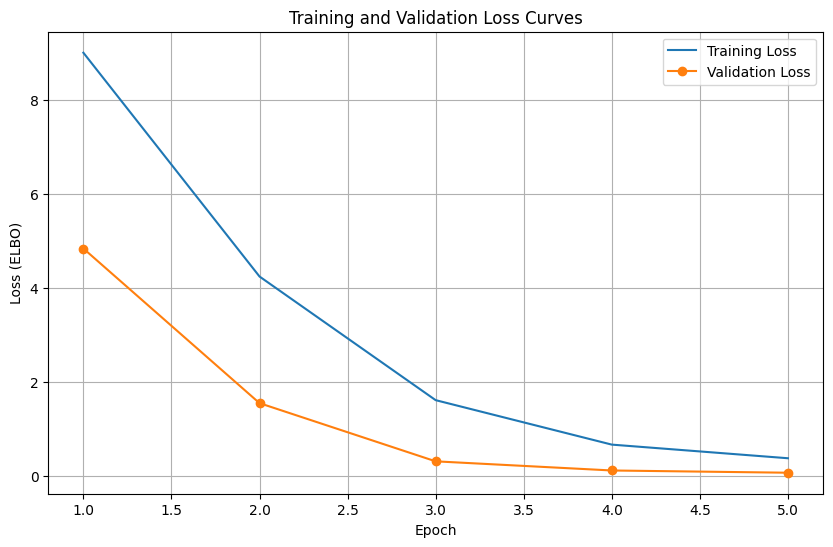

,IndividualID,HLA-A,HLA-B,HLA-DRB1,Population,AgeGroup
0,SAMPLE_0001,A*02/A*05,B*06/B*07,DRB1*02/DRB1*03,ASN,0-18
1,SAMPLE_0002,A*04/A*04,B*01/B*06,DRB1*01/DRB1*03,EUR,65+
2,SAMPLE_0003,A*01/A*01,B*06/B*06,DRB1*04/DRB1*04,ASN,65+
3,SAMPLE_0004,A*01/A*05,B*03/B*03,DRB1*01/DRB1*02,AFR,41-65
4,SAMPLE_0005,A*04/A*04,B*01/B*05,DRB1*02/DRB1*03,ASN,41-65


,IndividualID,Predicted_Haplotype1,Predicted_Haplotype2
0,SAMPLE_1502,A*02_B*02_DRB1*01,A*04_B*03_DRB1*01
1,SAMPLE_2587,A*01_B*01_DRB1*03,A*01_B*01_DRB1*04
2,SAMPLE_2654,A*02_B*07_DRB1*02,A*03_B*04_DRB1*03
3,SAMPLE_1056,A*01_B*06_DRB1*03,A*02_B*01_DRB1*01
4,SAMPLE_0706,A*01_B*04_DRB1*04,A*02_B*01_DRB1*04


In [22]:
# Plot loss curve after training
if train_losses and val_losses:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    val_epochs = [i + 1 for i, loss in enumerate(val_losses) if not np.isnan(loss)]
    valid_val_losses = [loss for loss in val_losses if not np.isnan(loss)]
    if valid_val_losses:
        plt.plot(val_epochs, valid_val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (ELBO)')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print('Loss histories not available, skipping plotting.')

# Show head of input data
display(df_unphased.head())

# Show head of predictions
display(predictions_df.head())